## Dynamic Single-Vehicle Properties of the Individual Driver Model (IDM)

### Special cases of the IDM acceleration

> According to the [paper](https://arxiv.org/abs/cond-mat/0002177).


### IDM Desired Gap Equation

The following equation defines the **desired minimum gap** in the Intelligent Driver Model (IDM):

$$
s^*(v, \Delta v) = s_0 + v T + \frac{v \cdot \Delta v}{2 \sqrt{a b}}
$$

#### Where:
- $s^*$: the **desired dynamic gap** to the leading vehicle  
- $s_0$: minimum distance (jam distance)  
- $v$: current speed of the following vehicle  
- $T$: desired time headway (in seconds), the amount of time a driver wants to maintain between themselves and the vehicle in front.  
- $\Delta v = v - v_{\text{lead}}$: approaching rate (difference in speed)  
- $a$: maximum acceleration  
- $b$: comfortable deceleration  


---

The term $\frac{v \cdot \Delta v}{2 \sqrt{a b}}$ represents a **dynamic braking term** — it grows when the vehicle is approaching another car quickly, making the model demand a larger gap to avoid collision.



### a. Equilibrium Traffic


A vehicle is in a traffic equilibrium when it maintains a **constant speed** and **constant gap** to the leading vehicle.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

> Read the .txt file that was created using [this traffic-simulator](https://traffic-simulation.de/).

### Column Descriptions for Traffic Simulation Data

`#time`: The timestamp (in seconds) of the simulation step.

`id`: A unique identifier for each vehicle.

`x[m]`, `y[m]`: The vehicle’s position in 2D Cartesian coordinates, measured in meters.

`speed[m/s]`: The vehicle's instantaneous speed, in meters per second.

`heading`: The vehicle’s direction of movement in **degrees**, usually from 0 to 360.
  - 0° = East  
  - 90° = North  
  - 180° = West  
  - 270° = South

`acc[m/s^2]`: The vehicle's acceleration at that time, in meters per second squared.

In [2]:
file_path = "low_inflow_on_ramp_flow.txt"

with open(file_path, encoding="utf-8") as f:
    lines = [line.strip().split("\t") for line in f.readlines()]

header = ["#time", "id", "x[m]", "y[m]", "speed[m/s]", "heading", "acc[m/s^2]"]

data = []
for row in lines[1:]:
    if len(row) == 8:
        row.pop(5)  
    if len(row) == 7:
        data.append(row)
    else:
        print("Row with unexpected number of columns:", row)

df = pd.DataFrame(data, columns=header)

for col in header:
    df[col] = pd.to_numeric(df[col], errors="coerce")

print(df.head())

   #time     id    x[m]  y[m]  speed[m/s]  heading  acc[m/s^2]
0    7.0  10622  663.30   0.0       15.52      0.0       -0.18
1    7.0  10623  633.00   1.0       16.53      0.0        0.31
2    7.0  10624  598.10   2.0       16.36      0.0       -0.07
3    7.0  10639  566.46   2.0       14.81      0.0        0.03
4    7.0  10625  559.10   0.0       15.36      0.0       -0.16


> Find the **vehicle infront** of every specific vehicle, the **approaching rate** and the **gap** between them. 

In [3]:
lane_tolerance = 0.5

for time, group in df.groupby("#time"):
    for idx, row in group.iterrows():
        ego_id = row["id"]
        ego_x = row["x[m]"]
        ego_y = row["y[m]"]
        ego_speed = row["speed[m/s]"]

        potential_leaders = group[
            (group["y[m]"].between(ego_y - lane_tolerance, ego_y + lane_tolerance)) &
            (group["x[m]"] > ego_x)
        ]

        if not potential_leaders.empty:
            leader = potential_leaders.loc[(potential_leaders["x[m]"] - ego_x).idxmin()]
            df.at[idx, "leader_id"] = leader["id"]
            df.at[idx, "leader_x"] = leader["x[m]"]
            df.at[idx, "leader_speed"] = leader["speed[m/s]"]

df["approaching_rate"] = df["speed[m/s]"] - df["leader_speed"]
df["gap"] = df["leader_x"] - df["x[m]"]
df

,#time,id,x[m],y[m],speed[m/s],heading,acc[m/s^2],leader_id,leader_x,leader_speed,approaching_rate,gap
0,7.0,10622,663.30,0.0,15.52,0.0,-0.18,NaN,NaN,NaN,NaN,NaN
1,7.0,10623,633.00,1.0,16.53,0.0,0.31,NaN,NaN,NaN,NaN,NaN
2,7.0,10624,598.10,2.0,16.36,0.0,-0.07,NaN,NaN,NaN,NaN,NaN
3,7.0,10639,566.46,2.0,14.81,0.0,0.03,10624.0,598.10,16.36,-1.55,31.64
4,7.0,10625,559.10,0.0,15.36,0.0,-0.16,10622.0,663.30,15.52,-0.16,104.20
...,...,...,...,...,...,...,...,...,...,...,...,...
2350,144.0,13885,224.05,2.0,14.95,0.0,0.21,13642.0,336.79,13.60,1.35,112.74
2351,144.0,13986,157.93,0.0,13.64,0.0,0.07,13723.0,258.83,10.87,2.77,100.90
2352,144.0,14052,113.52,2.0,11.78,0.0,0.15,13885.0,224.05,14.95,-3.17,110.53
2353,144.0,14153,69.86,1.0,13.52,0.0,0.38,13799.0,228.20,11.45,2.07,158.34


> If the **acceleration and the approaching rate** are **almost zero**, we are in the **equilibrium traffic** mode.

In [4]:
epsilon = 0.5  # Threshold for near-zero acceleration and approaching rate

df["equilibrium"] = (
    df["acc[m/s^2]"].abs() < epsilon
) & (df["approaching_rate"].abs() < epsilon)

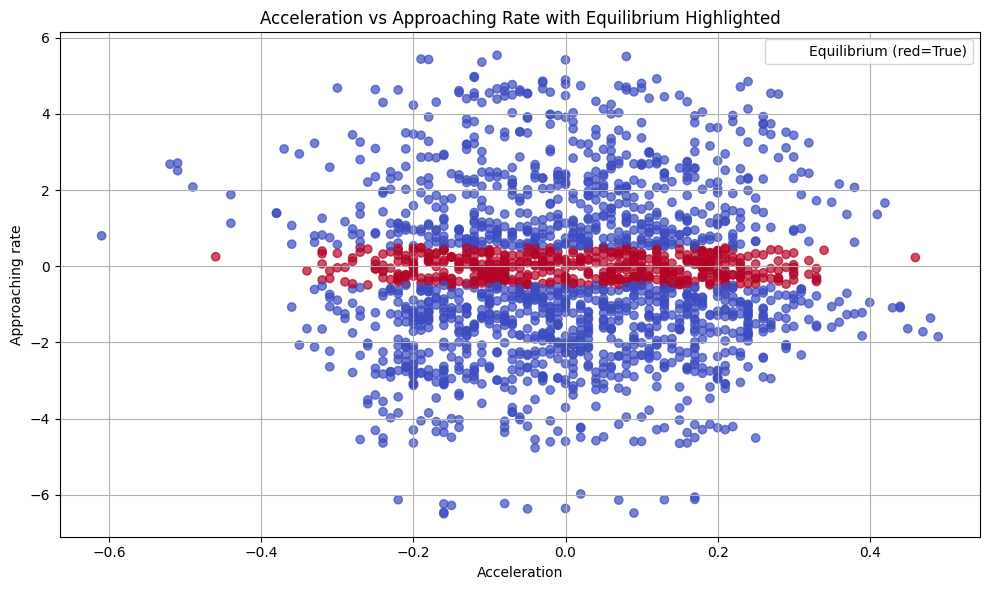

In [5]:
plt.figure(figsize=(10, 6))
plt.scatter(
    df["acc[m/s^2]"],
    df["approaching_rate"],
    c=df["equilibrium"],
    cmap="coolwarm",
    label="Equilibrium (red=True)",
    alpha=0.7,
)
plt.xlabel("Acceleration")
plt.ylabel("Approaching rate")
plt.title("Acceleration vs Approaching Rate with Equilibrium Highlighted")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### b. Acceleration to the Desired Velocity

When a vehicle 
- is not constrained by a leading vehicle (so we need to check that the gap is very big) and
- is accelerating toward its desired speed $v_0$.

> Import the file.

In [6]:
file_path = "low_traffic.txt"

with open(file_path, encoding="utf-8") as f:
    lines = [line.strip().split("\t") for line in f.readlines()]

header = ["#time", "id", "x[m]", "y[m]", "speed[m/s]", "heading", "acc[m/s^2]"]

data = []
for row in lines[1:]:
    if len(row) == 8:
        row.pop(5)
    if len(row) == 7:
        data.append(row)
    else:
        print("Row with unexpected number of columns:", row)

df = pd.DataFrame(data, columns=header)

for col in header:
    df[col] = pd.to_numeric(df[col], errors="coerce")

print(df.head())

   #time   id    x[m]  y[m]  speed[m/s]  heading  acc[m/s^2]
0   27.0  473  686.41   2.0       19.10      0.0        0.17
1   27.0  215  659.23   0.0       21.89      0.0        0.08
2   27.0  214  637.80   2.0       17.67      0.0        0.27
3   27.0  216  624.70   1.0       22.18      0.0       -0.00
4   27.0  542  588.69   2.0       11.35      0.0        0.46


> Extract and clean data.

> Find the leader of each vehicle (the vehicle infront).

In [7]:
lane_tolerance = 0.5

for time, group in df.groupby("#time"):
    for idx, row in group.iterrows():
        ego_id = row["id"]
        ego_x = row["x[m]"]
        ego_y = row["y[m]"]
        ego_speed = row["speed[m/s]"]

        # Filter same lane and ahead
        potential_leaders = group[
            (group["y[m]"].between(ego_y - lane_tolerance, ego_y + lane_tolerance)) &
            (group["x[m]"] > ego_x)
        ]

        if not potential_leaders.empty:
            leader = potential_leaders.loc[(potential_leaders["x[m]"] - ego_x).idxmin()]
            df.at[idx, "leader_id"] = leader["id"]
            df.at[idx, "leader_x"] = leader["x[m]"]
            df.at[idx, "leader_speed"] = leader["speed[m/s]"]


df["approaching_rate"] = df["speed[m/s]"] - df["leader_speed"]
df["gap"] = df["leader_x"] - df["x[m]"]

df.loc[df["leader_x"].isna(), "gap"] = np.nan
df["gap"] = df["gap"].clip(lower=0.1)       


In [8]:
df

,#time,id,x[m],y[m],speed[m/s],heading,acc[m/s^2],leader_id,leader_x,leader_speed,approaching_rate,gap
0,27.0,473,686.41,2.0,19.10,0.0,0.17,NaN,NaN,NaN,NaN,NaN
1,27.0,215,659.23,0.0,21.89,0.0,0.08,NaN,NaN,NaN,NaN,NaN
2,27.0,214,637.80,2.0,17.67,0.0,0.27,473.0,686.41,19.10,-1.43,48.61
3,27.0,216,624.70,1.0,22.18,0.0,-0.00,NaN,NaN,NaN,NaN,NaN
4,27.0,542,588.69,2.0,11.35,0.0,0.46,214.0,637.80,17.67,-6.32,49.11
...,...,...,...,...,...,...,...,...,...,...,...,...
3647,114.0,3100,100.78,0.0,20.43,0.0,0.18,3031.0,158.63,21.59,-1.16,57.85
3648,114.0,3116,84.71,2.0,19.49,0.0,0.01,3057.0,133.40,20.45,-0.96,48.69
3649,114.0,3142,62.10,1.0,18.62,0.0,0.15,3078.0,117.02,20.33,-1.71,54.92
3650,114.0,3158,56.51,0.0,20.36,0.0,-0.06,3100.0,100.78,20.43,-0.07,44.27


Requirements:
- The vehicle is in light traffic, free road and
- The vehicle moves slower than the desired speed.

In [9]:
# IDM Parameters
v0 = 30.0           # Desired speed [m/s]
delta = 4           # Acceleration exponent
a_max = 1.5         # Maximum acceleration [m/s^2]
epsilon_v = 0.1     # Speed tolerance

# The vehicle is in light traffic (no leader or a distant leader)
light_traffic = (df["gap"].isna()) | (df["gap"] > 50)

# The vehicle is moving slower than the desired speed
below_desired_speed = df["speed[m/s]"] < (v0 - epsilon_v)

# Vehicles accelerating toward desired speed under free-road conditions
accelerating_to_v0 = light_traffic & below_desired_speed

# Mark vehicles in this mode
df["accelerating_to_v0"] = accelerating_to_v0

In [10]:
df

,#time,id,x[m],y[m],speed[m/s],heading,acc[m/s^2],leader_id,leader_x,leader_speed,approaching_rate,gap,accelerating_to_v0
0,27.0,473,686.41,2.0,19.10,0.0,0.17,NaN,NaN,NaN,NaN,NaN,True
1,27.0,215,659.23,0.0,21.89,0.0,0.08,NaN,NaN,NaN,NaN,NaN,True
2,27.0,214,637.80,2.0,17.67,0.0,0.27,473.0,686.41,19.10,-1.43,48.61,False
3,27.0,216,624.70,1.0,22.18,0.0,-0.00,NaN,NaN,NaN,NaN,NaN,True
4,27.0,542,588.69,2.0,11.35,0.0,0.46,214.0,637.80,17.67,-6.32,49.11,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3647,114.0,3100,100.78,0.0,20.43,0.0,0.18,3031.0,158.63,21.59,-1.16,57.85,True
3648,114.0,3116,84.71,2.0,19.49,0.0,0.01,3057.0,133.40,20.45,-0.96,48.69,False
3649,114.0,3142,62.10,1.0,18.62,0.0,0.15,3078.0,117.02,20.33,-1.71,54.92,True
3650,114.0,3158,56.51,0.0,20.36,0.0,-0.06,3100.0,100.78,20.43,-0.07,44.27,False


### c. Breaking as Reaction to High Approaching Rates

> Triggered before the vehicle gets too close to the vehicle in front, just because it is getting too fast.

> The vehicle is braking mostly because it is closing in too fast, not because it's already too close.

In [11]:
import pandas as pd

file_path = "breaking_as_reaction_to_high_approaching_rates.txt"

# Step 1: Read lines and split by tab
with open(file_path, encoding="utf-8") as f:
    lines = [line.strip().split("\t") for line in f.readlines()]

# Step 2: Manually fix the header to match the actual number of columns in data
header = ["#time", "id", "x[m]", "y[m]", "speed[m/s]", "heading", "acc[m/s^2]"]

# Step 3: Process data rows
data = []
for row in lines[1:]:
    if len(row) == 8:
        # Heading is blank, remove extra field
        row.pop(5)  # remove empty heading field
    if len(row) == 7:
        data.append(row)
    else:
        print("Row with unexpected number of columns:", row)

# Step 4: Create DataFrame
df = pd.DataFrame(data, columns=header)

# Step 5: Convert relevant columns to numeric
for col in header:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# Step 6: Check output
print(df.head())


   #time     id    x[m]  y[m]  speed[m/s]  heading  acc[m/s^2]
0   12.5  62648  664.65   0.0       18.39      0.0        0.44
1   12.5  62662  661.29   2.0       17.06      0.0        0.35
2   12.5  62649  631.37   1.0       18.35      0.0        0.02
3   12.5  62650  594.22   2.0       17.88      0.0       -0.22
4   12.5  62651  563.07   0.0       18.53      0.0        0.03


> Identify the leader of each vehicle if it exists.

In [12]:
# Allow for small lane positioning errors
lane_tolerance = 0.5

for time, group in df.groupby("#time"):
    for idx, row in group.iterrows():
        ego_id = row["id"]
        ego_x = row["x[m]"]
        ego_y = row["y[m]"]
        ego_speed = row["speed[m/s]"]

        # Filter same lane and ahead
        potential_leaders = group[
            (group["y[m]"].between(ego_y - lane_tolerance, ego_y + lane_tolerance)) &
            (group["x[m]"] > ego_x)
        ]

        if not potential_leaders.empty:
            leader = potential_leaders.loc[(potential_leaders["x[m]"] - ego_x).idxmin()]
            df.at[idx, "leader_id"] = leader["id"]
            df.at[idx, "leader_x"] = leader["x[m]"]
            df.at[idx, "leader_speed"] = leader["speed[m/s]"]


In [13]:
df["approaching_rate"] = df["speed[m/s]"] - df["leader_speed"]
df["gap"] = df["leader_x"] - df["x[m]"]

Conditions: 
1. Approaching fast the vehicle in front.
2. Breaking a bit.
3. The dynamic term, that causes model braking, is dominating:


$$
dynamic term > 2 * (static gap)
$$


$$
\frac{v \cdot \Delta v}{2 \sqrt{a b}} > 2 \cdot \left( s_0 + v T \right)
$$

- $v$: speed of the follower (ego vehicle)  
- $\Delta v = v - v_{\text{leader}}$: approaching rate  
- $a$: maximum acceleration  
- $b$: comfortable deceleration  
- $s_0$: minimum gap (distance at standstill)  
- $T$: desired time headway

The dynamic term predicts how much extra space is needed to brake smoothly if you are approaching a slower vehicle.

The desired dynamic gap is: $s^*(v, \Delta v) = s_0 + vT + \frac{v \cdot \Delta v}{2 \sqrt{a b}}$.


In [14]:
# IDM parameters (you can tweak these)
a = 1.0       # max acceleration [m/s^2]
b = 2.0       # comfortable deceleration [m/s^2]
T = 1.5       # desired time headway [s]
s0 = 2.0      # minimum gap [m]

df['delta_v'] = df['speed[m/s]'] - df['leader_speed']

# Detect mode braking condition:
# - positive delta_v (approaching)
# - ego is braking (negative acceleration)
# - dynamic term dominates desired gap

df['mode_braking'] = (
    (df['delta_v'] > 1.0) &  # approaching fast
    (df['acc[m/s^2]'] < -0.1) &  # braking
    ((df['speed[m/s]'] * df['delta_v']) / (2 * np.sqrt(a * b)) > 2 * (s0 + df['speed[m/s]'] * T))  # dynamic term dominates
)

### d. Breaking in response to small gaps

Triggered when the **actual gap** becomes small compared to the desired gap $s^*$. It is basically when the vehicle gets too close to the vehicle in front.

The desired dynamic gap is: $s^*(v, \Delta v) = s_0 + vT + \frac{v \cdot \Delta v}{2 \sqrt{a b}}$.

In [15]:
# IDM parameters
s0 = 2.0    # Minimum gap [m]
T = 1.5     # Desired time headway [s]
a = 1.5     # Max acceleration [m/s^2]
b = 2.0     # Comfortable deceleration [m/s^2]
threshold = 1.0

# Avoid invalid values
valid_mask = df["leader_speed"].notna() & df["gap"].notna()

# Compute desired dynamic gap d
df["d_idm"] = np.nan
df.loc[valid_mask, "d_idm"] = (
    s0 +
    df.loc[valid_mask, "speed[m/s]"] * T +
    (df.loc[valid_mask, "speed[m/s]"] * df.loc[valid_mask, "approaching_rate"]) / (2 * np.sqrt(a * b))
)

df["gap_based_braking"] = (
    (df["d_idm"] > df["gap"]) & # the desired dynamic gap is bigger than the actual gap
    (df["approaching_rate"] <= threshold) &  # e.g., threshold = 1.0 m/s
    (df["acc[m/s^2]"] < 0)
)

In [16]:
df

,#time,id,x[m],y[m],speed[m/s],heading,acc[m/s^2],leader_id,leader_x,leader_speed,approaching_rate,gap,delta_v,mode_braking,d_idm,gap_based_braking
0,12.5,62648,664.65,0.0,18.39,0.0,0.44,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,False
1,12.5,62662,661.29,2.0,17.06,0.0,0.35,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,False
2,12.5,62649,631.37,1.0,18.35,0.0,0.02,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,False
3,12.5,62650,594.22,2.0,17.88,0.0,-0.22,62662.0,661.29,17.06,0.82,67.07,0.82,False,33.052439,False
4,12.5,62651,563.07,0.0,18.53,0.0,0.03,62648.0,664.65,18.39,0.14,101.58,0.14,False,30.543881,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14761,126.5,69000,66.06,1.0,18.68,0.0,0.14,68872.0,112.38,19.03,-0.35,46.32,-0.35,False,28.132642,False
14762,126.5,69042,56.55,0.0,20.34,0.0,-0.07,68919.0,104.51,20.05,0.29,47.96,0.29,False,34.212779,False
14763,126.5,69118,25.99,2.0,19.96,0.0,0.16,69006.0,68.91,19.88,0.08,42.92,0.08,False,32.400956,False
14764,126.5,69139,17.99,1.0,19.94,0.0,-0.03,69000.0,66.06,18.68,1.26,48.07,1.26,False,39.162790,False


### Create a classification model for these four behaviors using your .txt files

- Download files from [the traffic simulator](https://traffic-simulation.de/).
- Use the requirements from the modes to complete the conditions vector.

In [ ]:
import pandas as pd

file_path = "....txt"

# Step 1: Read lines and split by tab
with open(file_path, encoding="utf-8") as f:
    lines = [line.strip().split("\t") for line in f.readlines()]

# Step 2: Manually fix the header to match the actual number of columns in data
header = ["#time", "id", "x[m]", "y[m]", "speed[m/s]", "heading", "acc[m/s^2]"]

# Step 3: Process data rows
data = []
for row in lines[1:]:
    if len(row) == 8:
        # Heading is blank, remove extra field
        row.pop(5)  # remove empty heading field
    if len(row) == 7:
        data.append(row)
    else:
        print("Row with unexpected number of columns:", row)

# Step 4: Create DataFrame
df = pd.DataFrame(data, columns=header)

# Step 5: Convert relevant columns to numeric
for col in header:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# Step 6: Check output
print(df.head())


   #time     id    x[m]  y[m]  speed[m/s]  heading  acc[m/s^2]
0   12.5  62648  664.65   0.0       18.39      0.0        0.44
1   12.5  62662  661.29   2.0       17.06      0.0        0.35
2   12.5  62649  631.37   1.0       18.35      0.0        0.02
3   12.5  62650  594.22   2.0       17.88      0.0       -0.22
4   12.5  62651  563.07   0.0       18.53      0.0        0.03


In [8]:
df_sorted = df.sort_values(by=["#time", "y[m]", "x[m]"]).reset_index(drop=True)

# Initialize leader columns
df_sorted["leader_id"] = None
df_sorted["leader_x"] = None
df_sorted["leader_speed"] = None

In [9]:
# Allow for small lane positioning errors
lane_tolerance = 0.5

for time, group in df.groupby("#time"):
    for idx, row in group.iterrows():
        ego_id = row["id"]
        ego_x = row["x[m]"]
        ego_y = row["y[m]"]
        ego_speed = row["speed[m/s]"]

        # Filter same lane and ahead
        potential_leaders = group[
            (group["y[m]"].between(ego_y - lane_tolerance, ego_y + lane_tolerance)) &
            (group["x[m]"] > ego_x)
        ]

        if not potential_leaders.empty:
            leader = potential_leaders.loc[(potential_leaders["x[m]"] - ego_x).idxmin()]
            df.at[idx, "leader_id"] = leader["id"]
            df.at[idx, "leader_x"] = leader["x[m]"]
            df.at[idx, "leader_speed"] = leader["speed[m/s]"]


In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df["approaching_rate"] = df["speed[m/s]"] - df["leader_speed"]
df["gap"] = df["leader_x"] - df["x[m]"]

df.loc[df["leader_x"].isna(), "gap"] = np.nan
df["gap"] = df["gap"].clip(lower=0.1)

# Step 5: Only compute b_kin where leader_x and leader_speed exist
valid_leader_mask = df["leader_x"].notna() & df["leader_speed"].notna()
df["b_kin"] = np.nan
df.loc[valid_leader_mask, "b_kin"] = (df.loc[valid_leader_mask, "approaching_rate"] ** 2) / (2 * df.loc[valid_leader_mask, "gap"])

df["approaching_rate"] = df["speed[m/s]"] - df["leader_speed"]
df["b_kin"] = (df["approaching_rate"] ** 2) / (2 * df["gap"])


In [ ]:
b_comfort = 2.0
gap_threshold = 40
acc_threshold = 0.3
breaking_response_small_gaps_threshold = 1.0

conditions = [
    ("""Traffic equilibrium mode"""),

    ("""Free road mode"""),

    ("""Breaking as reaction to high approaching rates"""),

    ("""Breaking in response to small gaps"""),
]

labels = ["traffic equilibrium", "free_road", "breaking as reaction to high approaching rates", "breaking small gaps"]
df["behavior_mode"] = np.select(conditions, labels, default="other")

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="gap", y="speed[m/s]", hue="behavior_mode", alpha=0.7)
plt.title("Behavior Mode Classification")
plt.xlabel("Gap [m]")
plt.ylabel("Speed [m/s]")
plt.legend()
plt.grid(True)
plt.show()